In [22]:
# 导入必要的库
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import transforms, datasets, models, utils
from torchsummary import summary # 可视化训练过程
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from PIL import Image
from charset_normalizer import md__mypyc

In [23]:
# 分为为train, val, test定义transform
image_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(size=300, scale=(0.8, 1.1)), #功能：随机长宽比裁剪原始图片, 表示随机crop出来的图片会在的0.08倍至1.1倍之间
        transforms.RandomRotation(degrees=10), #功能：根据degrees随机旋转一定角度, 则表示在（-10，+10）度之间随机旋转
        transforms.ColorJitter(0.4, 0.4, 0.4), #功能：修改亮度、对比度和饱和度
        transforms.RandomHorizontalFlip(), #功能：水平翻转
        transforms.CenterCrop(size=256), #功能：根据给定的size从中心裁剪，size - 若为sequence,则为(h,w)，若为int，则(size,size)
        transforms.ToTensor(), #numpy --> tensor
        # 功能：对数据按通道进行标准化（RGB），即先减均值，再除以标准差
        transforms.Normalize([0.485, 0.456, 0.406],# mean
                             [0.229, 0.224, 0.225])# std 
    ]),
    
    'val' : transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],# mean
                             [0.229, 0.224, 0.225])# std 
    ]),
    
    'test' : transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],# mean
                             [0.229, 0.224, 0.225])# std 
    ])
}

In [24]:
# 加载数据集

# 数据集所在目录路径
data_dir = 'newDataset_binary/'
# train路径
train_dir = data_dir + 'train/'
# val路径
val_dir = data_dir + 'val/'
# test路径
test_dir = data_dir + 'test/'

# 从文件中读取数据
datasets = {
    'train' : datasets.ImageFolder(train_dir, transform=image_transforms['train']), # 读取train中的数据集，并transform
    'val' : datasets.ImageFolder(val_dir, transform=image_transforms['val']),  # 读取val中的数据集，并transform
    'test' : datasets.ImageFolder(test_dir, transform=image_transforms['test']) #  读取test中的数据集，并transform
}

# 定义BATCH_SIZE
BATCH_SIZE = 128 # 每批读取128张图片

# DataLoader : 创建iterator, 按批读取数据
dataloaders = {
    'train' : DataLoader(datasets['train'], batch_size=BATCH_SIZE, shuffle=True), # 训练集
    'val' : DataLoader(datasets['val'], batch_size=BATCH_SIZE, shuffle=True), # 验证集
    'test' : DataLoader(datasets['test'], batch_size=BATCH_SIZE, shuffle=True) # 测试集
}

# 创建label的键值对
LABEL = dict((v, k) for k, v in datasets['train'].class_to_idx.items())

LABEL

{0: 'BacterialPneumonia', 1: 'ViralPneumonia'}

In [25]:
# train 简介
dataloaders['train'].dataset

Dataset ImageFolder
    Number of datapoints: 6275
    Root location: newDataset_binary/train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(300, 300), scale=(0.8, 1.1), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [26]:
dataloaders['train'].dataset.classes # train下的类别

['BacterialPneumonia', 'ViralPneumonia']

In [27]:
dataloaders['train'].dataset.root # train的路径

'newDataset_binary/train/'

In [28]:
# 肺部细菌感染的图片
files_bcaterial_pneumonia = os.listdir(os.path.join(str(dataloaders['train'].dataset.root), 'BacterialPneumonia'))
files_bcaterial_pneumonia

['0.jpeg',
 '1.jpeg',
 '10.jpeg',
 '100.jpeg',
 '101.jpeg',
 '102.jpeg',
 '103.jpeg',
 '104.jpeg',
 '105.jpeg',
 '106.jpeg',
 '107.jpeg',
 '108.jpeg',
 '109.jpeg',
 '11.jpeg',
 '110.jpeg',
 '111.jpeg',
 '112.jpeg',
 '113.jpeg',
 '114.jpeg',
 '115.jpeg',
 '116.jpeg',
 '117.jpeg',
 '118.jpeg',
 '119.jpeg',
 '12.jpeg',
 '120.jpeg',
 '121.jpeg',
 '122.jpeg',
 '123.jpeg',
 '124.jpeg',
 '125.jpeg',
 '126.jpeg',
 '127.jpeg',
 '128.jpeg',
 '129.jpeg',
 '13.jpeg',
 '130.jpeg',
 '131.jpeg',
 '132.jpeg',
 '133.jpeg',
 '134.jpeg',
 '135.jpeg',
 '136.jpeg',
 '137.jpeg',
 '138.jpeg',
 '139.jpeg',
 '14.jpeg',
 '140.jpeg',
 '141.jpeg',
 '142.jpeg',
 '143.jpeg',
 '144.jpeg',
 '145.jpeg',
 '146.jpeg',
 '147.jpeg',
 '148.jpeg',
 '149.jpeg',
 '15.jpeg',
 '150.jpeg',
 '151.jpeg',
 '152.jpeg',
 '153.jpeg',
 '154.jpeg',
 '155.jpeg',
 '156.jpeg',
 '157.jpeg',
 '158.jpeg',
 '159.jpeg',
 '16.jpeg',
 '160.jpeg',
 '161.jpeg',
 '162.jpeg',
 '163.jpeg',
 '164.jpeg',
 '165.jpeg',
 '166.jpeg',
 '167.jpeg',
 '168.jpeg

In [29]:
# 肺部感染的图片
files_viral_pneumonia = os.listdir(os.path.join(str(dataloaders['train'].dataset.root), 'ViralPneumonia'))
files_viral_pneumonia

['0.jpeg',
 '1.jpeg',
 '10.jpeg',
 '100.jpeg',
 '101.jpeg',
 '102.jpeg',
 '103.jpeg',
 '104.jpeg',
 '105.jpeg',
 '106.jpeg',
 '107.jpeg',
 '108.jpeg',
 '109.jpeg',
 '11.jpeg',
 '110.jpeg',
 '111.jpeg',
 '112.jpeg',
 '113.jpeg',
 '114.jpeg',
 '115.jpeg',
 '116.jpeg',
 '117.jpeg',
 '118.jpeg',
 '119.jpeg',
 '12.jpeg',
 '120.jpeg',
 '121.jpeg',
 '122.jpeg',
 '123.jpeg',
 '124.jpeg',
 '125.jpeg',
 '126.jpeg',
 '127.jpeg',
 '128.jpeg',
 '129.jpeg',
 '13.jpeg',
 '130.jpeg',
 '131.jpeg',
 '132.jpeg',
 '133.jpeg',
 '134.jpeg',
 '135.jpeg',
 '136.jpeg',
 '137.jpeg',
 '138.jpeg',
 '139.jpeg',
 '14.jpeg',
 '140.jpeg',
 '141.jpeg',
 '142.jpeg',
 '143.jpeg',
 '144.jpeg',
 '145.jpeg',
 '146.jpeg',
 '147.jpeg',
 '148.jpeg',
 '149.jpeg',
 '15.jpeg',
 '150.jpeg',
 '151.jpeg',
 '152.jpeg',
 '153.jpeg',
 '154.jpeg',
 '155.jpeg',
 '156.jpeg',
 '157.jpeg',
 '158.jpeg',
 '159.jpeg',
 '16.jpeg',
 '160.jpeg',
 '161.jpeg',
 '162.jpeg',
 '163.jpeg',
 '164.jpeg',
 '165.jpeg',
 '166.jpeg',
 '167.jpeg',
 '168.jpeg

In [30]:
# val 简介
dataloaders['val'].dataset

Dataset ImageFolder
    Number of datapoints: 14
    Root location: newDataset_binary/val/
    StandardTransform
Transform: Compose(
               Resize(size=300, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [31]:
# test 简介
dataloaders['test'].dataset

Dataset ImageFolder
    Number of datapoints: 390
    Root location: newDataset_binary/test/
    StandardTransform
Transform: Compose(
               Resize(size=300, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### 提示：需要安装库：tb-nightly
### pip3 install tb-nightly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


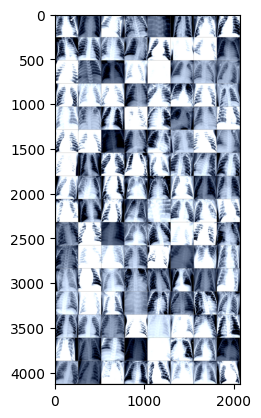

In [32]:
# 导入SummaryWriter
from torch.utils.tensorboard import SummaryWriter
# SummaryWriter() 向事件文件写入事件和概要

# 定义日志路径
log_path = 'logdir2/'

# 定义函数：获取tensorboard writer
def tb_writer():
    timestr = time.strftime("%Y%m%d_%H%M%S") # 时间格式
    writer = SummaryWriter(log_path+timestr) # 写入日志
    return writer


writer = tb_writer()

# 第1种方法：显示部分图片集
images, labels = next(iter(dataloaders['train'])) # 获取到一批数据

# 定义图片显示方法
def imshow(img):
    img = img / 2 + 0.5 # 逆正则化
    np_img = img.numpy() # tensor --> numpy
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # 改变通道顺序
    plt.show()
    
grid = utils.make_grid(images) # make_grid的作用是将若干幅图像拼成一幅图像
imshow(grid) # 展示图片

# 在summary中添加图片数据
writer.add_image('X-Ray grid', grid, 0) # add_image(tag, img_tensor, global_step=None, walltime=None, dataformats='CHW')

writer.flush() # 把事件文件写入到磁盘

In [33]:
# 获取一张图片tensor
dataloaders['train'].dataset[4] # 返回：tensor, label

(tensor([[[ 0.8447,  0.2111, -1.1589,  ..., -0.7479, -0.7822, -0.7308],
          [ 0.8618,  0.2796, -1.4672,  ..., -0.7993, -0.7993, -0.7822],
          [ 0.1768,  0.7077, -0.6281,  ..., -0.6281, -0.7308, -0.6109],
          ...,
          [-0.7137, -0.4911, -0.2856,  ..., -2.1179, -2.1179, -2.1179],
          [-0.6965, -0.4568, -0.2856,  ..., -2.1179, -2.1179, -2.1179],
          [-0.6965, -0.4054, -0.3027,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[ 0.9930,  0.3452, -1.0553,  ..., -0.6352, -0.6702, -0.6176],
          [ 1.0105,  0.4153, -1.3704,  ..., -0.6877, -0.6877, -0.6702],
          [ 0.3102,  0.8529, -0.5126,  ..., -0.5126, -0.6176, -0.4951],
          ...,
          [-0.6001, -0.3725, -0.1625,  ..., -2.0357, -2.0357, -2.0357],
          [-0.5826, -0.3375, -0.1625,  ..., -2.0357, -2.0357, -2.0357],
          [-0.5826, -0.2850, -0.1800,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[ 1.2108,  0.5659, -0.8284,  ..., -0.4101, -0.4450, -0.3927],
          [ 1.2282,  0.6356,

Label :  BacterialPneumonia


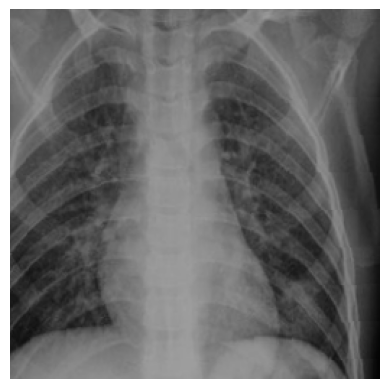

In [34]:
# 第2种方法：显示一张图片
def show_sample(img, label):
    print("Label : ", dataloaders['train'].dataset.classes[label]) # 输出标签
    img = img.numpy().transpose((1, 2, 0)) # 改变shape顺序
    mean = np.array([0.485, 0.456, 0.406]) # 均值
    std = np.array([0.229, 0.224, 0.225]) # 标准差
    img = img * std + mean # 逆向复原
    img = np.clip(img, 0, 1) # np.clip() 将inp中的元素值限制在(0,1)之间，最小值为0，最大值为1。小于min的等于min，大于max等于max
    plt.imshow(img)
    plt.axis('off') # 关闭坐标轴

show_sample(*dataloaders['train'].dataset[4]) # 显示第5张图片

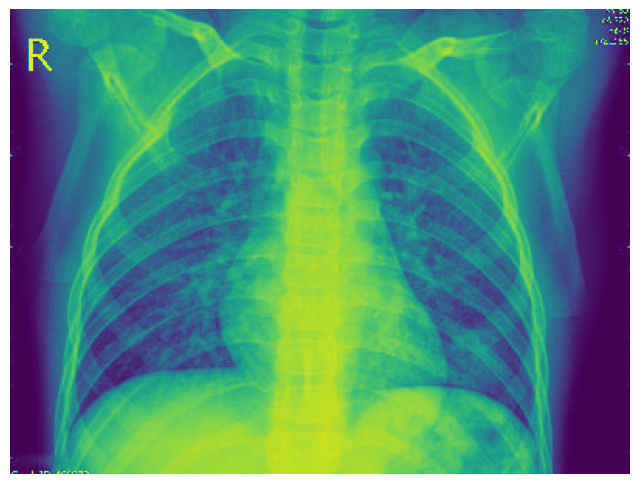

In [35]:
# 第3种方法：显示一张图片
def show_image(img):
    plt.figure(figsize=(8,8)) # 显示大小
    plt.imshow(img) # 显示图片
    plt.axis('off') # 关闭坐标轴
    plt.show()
    
# 读取图片
one_img = Image.open(dataloaders['train'].dataset.root+'BacterialPneumonia/101.jpeg')

# 调用函数
show_image(one_img)

In [36]:
# 记录错误分类的图片
def misclassified_images(pred, writer, target, images, output, epoch, count=10):
    misclassified = (pred != target.data) # 判断是否一致
    for index, image_tensor in enumerate(images[misclassified][:count]):
        img_name = 'Epoch:{}-->Predict:{}-->Actual:{}'.format(epoch, LABEL[pred[misclassified].tolist()[index]],
                                                              LABEL[target.data[misclassified].tolist()[index]])
        writer.add_image(img_name, image_tensor, epoch)

In [37]:
# 自定义池化层

class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, size=None):
        super(AdaptiveConcatPool2d,self).__init__()
        size = size or (1, 1) # kernel大小
        # 自适应算法能够自动帮助我们计算核的大小和每次移动的步长。
        self.avgPooling = nn.AdaptiveAvgPool2d(size) # 自适应平均池化
        self.maxPooling = nn.AdaptiveMaxPool2d(size) # 最大池化
    def forward(self, x):
        # 拼接avg和max
        return torch.cat([self.maxPooling(x), self.avgPooling(x)], dim=1)

In [38]:
# 迁移学习：获取预训练模型，并替换池化层和全连接层
def get_model():
    # 获取欲训练模型 restnet50
    model = models.resnet50(pretrained=True) 
    # 冻结模型参数
    for param in model.parameters():
        param.requires_grad = False 
    # 替换最后2层：池化层和全连接层
    # 池化层
    model.avgpool = AdaptiveConcatPool2d()
    # 全连接层
    model.fc = nn.Sequential(
        nn.Flatten(), # 拉平
        nn.BatchNorm1d(4096), # 加速神经网络的收敛过程，提高训练过程中的稳定性
        nn.Dropout(0.5), # 丢掉部分神经元
        nn.Linear(4096, 512), # 全连接层
        nn.ReLU(), # 激活函数
        nn.BatchNorm1d(512), 
        nn.Dropout(0.5),
        nn.Linear(512, 2), # 2个输出
        nn.LogSoftmax(dim=1) # 损失函数：将input转换成概率分布的形式，输出2个概率
    )
    return model


In [39]:
# 定义训练函数
def train_val(model, device, train_loader, val_loader, optimizer, criterion, epoch, writer):
    model.train()
    total_loss = 0.0
    val_loss = 0.0
    val_acc = 0
    for batch_id, (images, labels) in enumerate(train_loader):
        # 部署到device上
        images, labels = images.to(device), labels.to(device)
        # 梯度置0
        optimizer.zero_grad()
        # 模型输出
        outputs = model(images)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 累计损失
        total_loss += loss.item() * images.size(0)
    # 平均训练损失
    train_loss = total_loss / len(train_loader.dataset)
    #写入到writer中
    writer.add_scalar('Training Loss', train_loss, epoch)
    # 写入到磁盘
    writer.flush()
    
    model.eval() 
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # 前向传播输出
            loss = criterion(outputs, labels) # 损失
            val_loss += loss.item() * images.size(0) # 累计损失
            _, pred = torch.max(outputs, dim=1) # 获取最大概率的索引
            correct = pred.eq(labels.view_as(pred)) # 返回：tensor([ True,False,True,...,False])
            accuracy = torch.mean(correct.type(torch.FloatTensor)) # 准确率
            val_acc += accuracy.item() * images.size(0) # 累计准确率
        # 平均验证损失
        val_loss = val_loss / len(val_loader.dataset)
        # 平均准确率
        val_acc = val_acc / len(val_loader.dataset)
        
    return train_loss, val_loss, val_acc 

In [40]:
# 定义测试函数
def test(model, device, test_loader, criterion, epoch, writer):
    model.eval()
    total_loss = 0.0
    correct = 0.0 # 正确数
    with torch.no_grad():
        for batch_id, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            # 输出
            outputs = model(images)
            # 损失
            loss = criterion(outputs, labels)
            # 累计损失
            total_loss += loss.item()
            # 获取预测概率最大值的索引
            _, predicted = torch.max(outputs, dim=1)
            # 累计正确预测的数
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            # 错误分类的图片
            misclassified_images(predicted, writer, labels, images, outputs, epoch)
        # 平均损失
        avg_loss = total_loss / len(test_loader.dataset)
        # 计算正确率
        accuracy = 100 * correct / len(test_loader.dataset)
        # 将test的结果写入write
        writer.add_scalar("Test Loss", total_loss, epoch)
        writer.add_scalar("Accuracy", accuracy, epoch)
        writer.flush()
        return total_loss, accuracy

In [41]:
# 定义训练流程

# 是否有GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device.type)

# 模型部署到device
model = get_model().to(device)

# 损失函数
criterion = nn.NLLLoss()

# 优化器
optimizer = optim.SGD(model.parameters(), lr=0.001)

# 定义训练流程函数
def train_epochs(model, device, dataloaders, criterion, optimizer, epochs, writer):
    # 输出信息
    print("{0:>15} | {1:>15} | {2:>15} | {3:>15} | {4:>15} | {5:>15}".format('Epoch', 'Train Loss', 'val_loss', 'val_acc', 'Test Loss', 'Test_acc'))
    # 初始最小的损失
    best_loss = np.inf
    # 开始训练、测试
    for epoch in range(epochs):
        # 训练，return: loss
        train_loss, val_loss, val_acc = train_val(model, device, dataloaders['train'], dataloaders['val'], optimizer, criterion, epoch, writer)
        # 测试，return: loss + accuracy
        test_loss, test_acc = test(model, device, dataloaders['test'], criterion, epoch, writer)
        # 判断损失是否最小
        if test_loss < best_loss:
            best_loss = test_loss # 保存最小损失
            # 保存模型
            torch.save(model.state_dict(), 'model2.pth')
        # 输出结果
        print("{0:>15} | {1:>15} | {2:>15} | {3:>15} | {4:>15} | {5:>15}".format(epoch, train_loss, val_loss, val_acc, test_loss, test_acc))
        writer.flush()

cuda


In [42]:
# 调用函数
epochs=40
train_epochs(model, device, dataloaders, criterion, optimizer, epochs, writer)
writer.close()

          Epoch |      Train Loss |        val_loss |         val_acc |       Test Loss |        Test_acc
              0 | 0.7570857312764779 | 0.6021243929862976 | 0.6428571343421936 | 2.3546782732009888 | 67.17948717948718
              1 | 0.6846864085653389 | 0.5891879200935364 | 0.5714285969734192 | 2.060671627521515 | 80.51282051282051
              2 | 0.6433870753467795 | 0.6277446150779724 | 0.5714285969734192 | 2.093055874109268 | 79.74358974358974
              3 | 0.648135487681841 | 0.6485794186592102 | 0.5714285969734192 | 1.9326706230640411 | 79.48717948717949
              4 | 0.6328748155970022 | 0.7093262672424316 | 0.5714285969734192 | 2.126344919204712 | 79.48717948717949
              5 | 0.6211268366950442 | 0.6904856562614441 |             0.5 | 1.9910016655921936 | 80.76923076923077
              6 | 0.6147208723497106 | 0.6646482348442078 |             0.5 | 1.8360626697540283 | 81.02564102564102
              7 | 0.6100208991979698 | 0.7069896459579468 |     

In [43]:
def plot_confusion(cm):
    plt.figure()
    plot_confusion_matrix(cm, figsize=(12, 8), cmap=plt.cm.Blues) # 参数设置
    plt.xticks(range(2), ['BacterialPneumonia', 'ViralPneumonia'], fontsize=14)
    plt.yticks(range(2), ['BacterialPneumonia', 'ViralPneumonia'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.show()

In [44]:
# def accuracy(outputs, labels):
#     # 计算正确率
#     _, preds = torch.max(outputs, dim=1)
#     correct = torch.tensor(torch.sum(preds == labels).item() / len(preds))
#     return correct

In [45]:
# def metrics(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     # precision, recall, F1
#     # 混淆矩阵
#     cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
#     # 绘制混淆矩阵
#     plot_confusion(cm) 
#     # 获取tn, fp, fn, tp
# #     tn, fp, fn, tp = cm.ravel()
#     fp = cm.sum(axis=0) - np.diag(cm)
#     fn = cm.sum(axis=1) - np.diag(cm)
#     tp = np.diag(cm)
#     tn = cm.sum() - (fp + fn + tp)
#     print(tn)
#     print(fp)
#     # 精准率
#     precision = tp / (tp + fp)
#     # 召回率
#     recall = tp / (tp + fn)
#     # f1 score
#     f1 = 2 * ((precision * recall) / (precision + recall))
#     return precision, recall, f1

<Figure size 640x480 with 0 Axes>

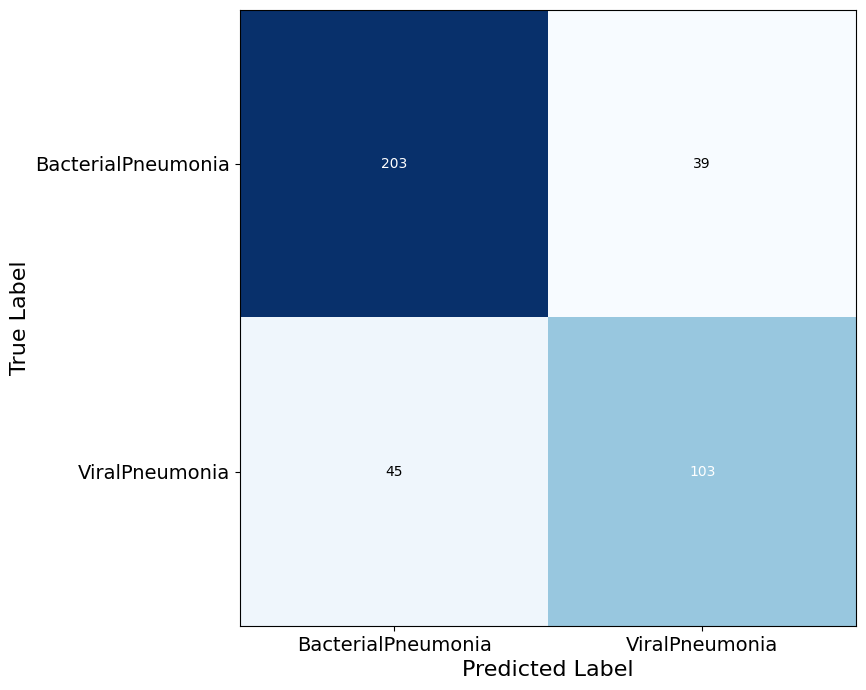

0.7253521126760564
0.6959459459459459
0.7103448275862069
0.7846153846153846


In [46]:
all_preds = []
all_labels = []

with torch.no_grad():
    model.eval()
    for datas, labels in dataloaders['test']:
        datas, labels = datas.to(device), labels.to(device)
        # 预测输出 前向传播
        outputs = model(datas)
        _, preds = torch.max(outputs, dim=1)
#     将预测结果和真实标签添加到列表中
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        # precision, recall, F1
        # 混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    # 绘制混淆矩阵
    plot_confusion(cm) 
#     fp = cm.sum(axis=0) - np.diag(cm)
#     fn = cm.sum(axis=1) - np.diag(cm)
#     tp = np.diag(cm)
#     tn = cm.sum() - (fp + fn + tp)
    tn, fp, fn, tp = cm.ravel()
    # 精准率
    precision = tp / (tp + fp)
    # 召回率
    recall = tp / (tp + fn)
    # f1 score
    f1 = 2 * ((precision * recall) / (precision + recall))
    num_correct = 0
    num_total = len(all_labels)
    for pred, label in zip(all_preds, all_labels):
        if pred == label:
            num_correct += 1
            acc = num_correct / num_total
#     acc = torch.tensor(torch.sum(all_preds == all_labels.data).item() / len(all_preds))
    print(precision)
    print(recall)
    print(f1)
    print(acc)

# with torch.no_grad():
#     model.eval()
#     for datas, labels in dataloaders['val']:
#         datas, labels = datas.to(device), labels.to(device)
#         # 预测输出
#         outputs = model(datas)
#         # 计算metrics
#         precision, recall, f1 = metrics(outputs, labels)
#         acc = accuracy(outputs, labels)
#         # 保存结果
#         precisions.append(precision)
#         recalls.append(recall)
#         f1s.append(f1)
#         accuracies.append(acc.item())
#         print(precisions)
#         print(recalls)

In [47]:
# ['{:.2f}%'.format(pre*100) for pre in precisions]# 精准率 precision

In [48]:
# ['{:.2f}%'.format(r*100) for r in recalls]# 召回率 recall

In [49]:
# ['{:.2f}%'.format(f*100) for f in f1s]# f1

In [50]:
# ['{:.2f}%'.format(a*100) for a in accuracies]# 准确率 accuracy